# Comparison of various Sibling Detection Approaches, including Beverly, Hand-Tuned, and Machine-Learning

For questions and comments, please contact me under scheitle@net.in.tum.de

In [814]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from IPython.display import Image  
import pandas
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

Versions:
    * Python: 3.5.3
    * numpy: 1.12.1
    * pandas: 0.19.2
    * sklearn: 0.18.1
    * matplotlib 2.0.0
    * jupyter notebook 5.0.0

In [815]:
def get_pd_files(folder):
    sibf = folder + "hosts.csvcapture.pcap.ts.siblingresult.csv"
    nonsibf = folder + "hosts.csv__nonsiblings_seed1_n*capture.pcap.ts.siblingresult.csv"
    import glob
    for filename in glob.glob(nonsibf):
        nonsibf = filename
    import os.path
    if os.path.isfile(sibf) and os.path.isfile(nonsibf):
        print("Loading from filenames {} and {}".format(sibf, nonsibf))
    else:
        print("Files not found {} and {}".format(sibf, nonsibf))
        
    sib = pd.read_csv(sibf, index_col=0)
    sib['label'] = 1
    nonsib = pd.read_csv(nonsibf, index_col=0)
    nonsib['label'] = 0
    print("Read {} siblings and {} non-siblings from files.".format(len(sib), len(nonsib)))
    return sib, nonsib
       
def dec2prd_ours(df):
    df.loc[df["decision"].str.contains("^sibling"), "dec_prd"] =  1
    df.loc[df["decision"].str.contains("^non-sibling"), "dec_prd"] =  0
    return  # df is changed in place so no returning necessary

def dec2prd_bev(df):
    df.loc[df["dec_bev"].str.contains("^sibling"), "dec_bev_prd"] =  1
    df.loc[df["dec_bev"].str.contains("^non-sibling"), "dec_bev_prd"] =  0
    return  # df is changed in place so no returning necessary

def mix_sib_nonsib(sib, nonsib, mode, rs=42):
    if mode == "equal":
        nonsibint = nonsib.sample(n=len(sib), replace=True, weights=None, random_state=rs)
    else:
        nonsibint = nonsib
    datain = pd.concat([sib,nonsibint])
    return datain


def get_ouralgo_stats(sib, nonsib):
    #print("Our algo stats:")
    df = mix_sib_nonsib(sib, nonsib, "full", 42)
    df_ours = df[["label", "decision"]].copy()
    dec2prd_ours(df_ours)
    undec = len(df_ours[df_ours.isnull().any(axis=1)])
    print("Our algo: Not deciding on {} pairs for unknown/error reasons.".format(undec))
    df_ours = df_ours.dropna()
    weights = get_sample_weight_one_input(df_ours)
    mcc = matthews_corrcoef(df_ours["label"], df_ours["dec_prd"], sample_weight=None)
    f1 = f1_score(df_ours["label"], df_ours["dec_prd"], sample_weight=None)
    print("Our algo stats: ({}) undecided, mcc: {}, f1: {}".format(undec, mcc, f1))
    statsv = list(stats(df_ours["label"], df_ours["dec_prd"]))
    statsv.append(mcc)
    return statsv

def get_bev_stats(sib, nonsib):
    df = mix_sib_nonsib(sib, nonsib, "full", 42)
    df_tmp = df[["label", "dec_bev"]].copy()
    dec_nan = len(df_tmp[df_tmp["dec_bev"].isnull() == True])
    df_tmp = df_tmp[df_tmp["dec_bev"].isnull() == False]
    dec2prd_bev(df_tmp)
    undec = len(df_tmp[df_tmp.isnull().any(axis=1)])
    df_tmp = df_tmp.dropna()
    weights = get_sample_weight_one_input(df_tmp)
    mcc = matthews_corrcoef(df_tmp["label"], df_tmp["dec_bev_prd"], sample_weight=None)
    f1 = f1_score(df_tmp["label"], df_tmp["dec_bev_prd"], sample_weight=None)
    print("Beverly algo: Not deciding on {} pairs for NaN and {} pairs for unknown/error reasons.".format(dec_nan, undec))
    print("Beverly algo stats: ({}) undecided, mcc: {}, f1: {}".format(undec, mcc, f1))
    statsv =  list(stats(df_tmp["label"], df_tmp["dec_bev_prd"]))
    statsv.append(mcc)
    return statsv
    

def match_nonsibs_slow(sib, nonsib, rs=42):
    ctr = 0 
    for i, ii in sib.iterrows():
        for j, jj in sib.iterrows():
            if ii[1] != jj[1]:
                nscand = ii[1] + "_+_" +  jj[1]
                ctr += 1 
    return
                
def match_nonsibs(sib, nonsib, rs=42):
    ctr = 0 
    a = []
    sd = dict() # siblings dict
    nsd = dict()  # non siblings dict
    for i in sib.itertuples():
        sd[i[0]] = 0
    for i in nonsib.itertuples():
        nsd[i[0]] = 0
    nscand = dict()
    #nstmp = pandas.DataFrame()
    for i in sd.keys():
        for j in sd.keys():
            if i != j:
                nscandstr = i + "_+_" +  j
                nscand[nscandstr] = 1
    print("Generated {} non-sibling candidates from {} siblings.".format(len(nscand), len(sib)))
    fails = []
    for k1 in nsd.keys():
        if k1 not in nscand.keys():
            fails.append(k1)
            #print("fail! {} ".format(i))    
    nsfiltered = nonsib.copy()
    nsfiltered.drop(fails, inplace=True)
    return nsfiltered

def assign_groups_old(datain):
    datain["group"] = "servers"
    datain.loc[datain["domain"].str.contains("nlnog.net"), "group"] = "nlnog"
    datain.loc[datain["domain"].str.contains("RA_"), "group"] = "RA"
    datain.loc[datain["domain"].str.extract("RA_([0-9]{4})") < 6019, "group"] = "RAv1"
    datain.loc[datain["domain"].str.extract("RA_([0-9]{4})") > 6018, "group"] = "RAv2"
    return

def assign_groups(datain):
    datain["group"] = "servers"
    #sib.loc[sib.index.str.contains("nlnog.net"), "group"] = "nlnog"
    datain.loc[datain.index.str.contains("nlnog.net"), "group"] = "nlnog"
    datain.loc[datain.index.str.contains("RA_"), "group"] = "RA"
    datain["ra_id"] = datain.index.str.extract("RA_([0-9]{4})", expand=False).astype(float).fillna(0).astype(int) 
    datain.loc[(datain.ra_id > 5999) & (datain.ra_id < 6019), "group"] = "RAv1"
    datain.loc[datain.ra_id > 6018, "group"] = "RAv2"    
    groups = datain["group"].as_matrix()
    return groups
    
    
def prune_datain(datain):
    errorc = len(datain[datain["decision"].str.contains("ERROR|error") == True])
    print("Removing {} errors values from datain.".format(errorc))
    datain = datain[datain["decision"].str.contains("ERROR|error") == False]

    hzdiffc = len(datain[datain["hzdiff"] != 0])
    print("Deciding {} hzdiff hosts as non-sib, stats:".format(hzdiffc))
    lbl = datain[datain["hzdiff"] != 0]["label"]
    prd = lbl.copy()
    prd[:] = 0
    stats(lbl,prd)
    dataout = datain[datain["hzdiff"] == 0]
    return dataout, lbl, prd

def prune_data_for_ml(datain):
    # problem: NaNs might be in non-feature columns such as RA_ID
    erridx = datain[datain.decision.str.contains("ERROR|error") == True].index
    labels, features = make_labels_features(datain)
    naidx = datain[features.isnull().any(axis=1) == True].index
    bothidx = erridx | naidx
    dataout = datain.drop(bothidx)
    lbl = datain.loc[bothidx, "label"]
    prd = lbl.copy()
    prd[:] = 0
    stats(lbl,prd)    
    print("Removing {} rows with error results and {} rows with NaNs (typically hz different) from a \
    total of {} entries, resulting in {} entries.".format(
            len(erridx), len(naidx), len(datain), len(dataout)))
    return dataout, lbl, prd


def stats(lbl, prd):
        tp = np.sum((lbl == 1) & (prd == 1)) 
        fp = np.sum(lbl < prd ) 
        tn = np.sum((lbl == 0) & (prd == 0)) 
        fn = np.sum(lbl > prd ) 
        try:
            prec =  round(100*tp/(tp+fp),2) # TPR?
            recall = round(100*tp/(tp+fn),2) 
            spec= round(100*tn/(tn+fp),2) # TNR?
            acc = round(100*(tn+tp)/(tn+fn+fp+tp),2)
        except ZeroDivisionError as e:
            print("Catching ZeroDivisionError at stats!")
            prec = 0
            recall = 0
            spec = 0
            acc = 0
        print("Correct: {}, incorrect {}, TP {}, FP {}, TN {}, FN{}, Prec. {}, Rec. {}, Spec. {}, Acc. {}%".format(
        np.sum(lbl == prd),
        np.sum(lbl != prd),
        tp, fp, tn, fn, 
        prec, recall, spec, acc
        ))
        return prec, recall, spec, acc
        
def make_labels_features(dfin):
    labels = dfin["label"]
    features = dfin[["hzdiff", "hzr2diff", "timestamps_diff", "adiff", 
                        "theta", "r2diff", "ott_rng_diff_rel", "optsdiff",
                       "perc_85_val"]].copy()
    features["hzr2mean"] = (dfin["hz4r2"] + dfin["hz6r2"])  / 2.0
    features["r2mean"] = (dfin["r4_sqr"] + dfin["r6_sqr"]) / 2.0     
    features["ott_rng_mean"] = (dfin["ott4_rng"] + dfin["ott6_rng"]) / 2.0
    features["splinediff_scaled"] = dfin["perc_85_val"] / features["ott_rng_mean"]
    return labels, features   

def get_sample_weight(sib, nonsib):
    sl = len(sib)
    nsl = len(nonsib)
    tl = sl + nsl
    nsw = sl / tl
    sw = nsl / tl
    print("Found {} sibs and {} nonsibs, weights: {} and {}".format(sl, nsl, sw, nsw))
    weight = np.zeros(len(datain))
    weight = np.float32(datain["label"].as_matrix())
    weight[weight == 1] = sw
    weight[weight == 0] = nsw
    
    
def get_sample_weight_one_input(dfin):
    sl = len(dfin[dfin["label"] == 1])
    nsl = len(dfin[dfin["label"] == 0])
    tl = sl + nsl
    nsw = sl / tl
    sw = nsl / tl
    weight = np.zeros(len(dfin))
    weight = np.float32(dfin["label"].as_matrix())
    weight[weight == 1] = sw
    weight[weight == 0] = nsw
    print("Found {} sibs and {} nonsibs, weights: {} and {}, #weights: {}".format(
        sl, nsl, round(sw,4), round(nsw,4), len(weight)))
    return weight


# functions for ML with proprtional group sampling
def split_stratified_groups(sib, splits, nr):
    from sklearn.model_selection import KFold # non-overlapping!
    groups = assign_groups(sib)
    groupset = set(groups)
    gsibdf_train = pd.DataFrame(columns=sib.columns)
    gsibdf_test = pd.DataFrame(columns=sib.columns)
    for i in groupset:
        groupsib = sib[sib["group"] == i].copy()
        if len(groupsib ) < splits:
            # can not split into more folds than files...
            print("ERROR: more splits ({}) than samples ({}), reducing to sample nr".format(splits, len(groupsib)))
            splits = len(groupsib)
        #print("## GROUP: {} with {} elements.".format(i, len(groupsib)))
        ks = KFold(n_splits=splits, random_state=42, shuffle=True)
        labels, features = make_labels_features(groupsib)
        ctr = -1
        for train_index, test_index in ks.split(groupsib):
            ctr += 1                
            if (ctr == nr):
            #print("TRAIN:", train_index, "TEST:", test_index)
                gsibdf_train = gsibdf_train.append(groupsib.iloc[train_index])
                gsibdf_test = gsibdf_test.append(groupsib.iloc[test_index])
                break
    return [gsibdf_train, gsibdf_test]


def dt_train(labels, features, weight, rs=42):
    estimator = DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=42)
    est = estimator.fit(features, labels, sample_weight=weight)
    return est

def kfold_train_test(sib, nonsib):
    kfolds = 10
    stats_train_error = np.empty((10,5), dtype=float)
    stats_test_error = np.empty((10,5), dtype=float)
    graphs = []
    for i in range(10):
        print("Round {}".format(i))
        # pick proportionally from each group
        train_sib, test_sib = split_stratified_groups(sib, 10, i)
        # create, select, and mix matching nonsibs
        train_nonsib = match_nonsibs(train_sib, nonsib)
        test_nonsib = match_nonsibs(test_sib, nonsib)
        train = mix_sib_nonsib(train_sib,train_nonsib, "all")
        # prune NaNs out
        train, train_prune_lbl, train_prune_prd = prune_data_for_ml(train)
        test = mix_sib_nonsib(test_sib,test_nonsib, "all")
        test, test_prune_lbl, test_prune_prd = prune_data_for_ml(test)
        # split out features, labels, and weights
        train_lbl, train_ftr = make_labels_features(train)
        test_lbl, test_ftr = make_labels_features(test)
        train_weight = get_sample_weight_one_input(train)
        test_weight = get_sample_weight_one_input(test)
        # train estimator
        est = dt_train(train_lbl, train_ftr, train_weight)   
        mcc = matthews_corrcoef(train_lbl, est.predict(train_ftr), sample_weight=train_weight)
        statsv = list(stats(train_lbl, est.predict(train_ftr)))
        statsv.append(mcc)
        stats_train_error[i] = statsv
        #print("test error: mcc of {}".format(mcc))
        mcc = matthews_corrcoef(test_lbl, est.predict(test_ftr), sample_weight=test_weight)
        statsv = list(stats(test_lbl, est.predict(test_ftr)))
        statsv.append(mcc)
        stats_test_error[i] = statsv
        #stats_test_error[i]  =  stats(test_lbl, est.predict(test_ftr))
        graph = dt_plot(est, train_ftr)
        graphs.append(graph)
        #Image(graph.create_png())  
    return stats_train_error, stats_test_error, graphs

# One function to evaluate them all

In [867]:
runs = 8
hlostats = np.zeros((runs-1,5), dtype=float)
hlbstats = np.zeros((runs-1,5), dtype=float)
gsdo =  dict() # group stats dict
gsdb =  dict() # group stats dict
mlstatsd_tee = dict()
mlstatsd_tre = dict()
graphs = []
for i in range(1,runs):
    print("############# Round {} ##############".format(i))
    sib, nonsib = get_pd_files("../../../gt{}/".format(i))
    # high level
    hlostats[i - 1] = tuple(get_ouralgo_stats(sib, nonsib))
    hlbstats[i - 1] = get_bev_stats(sib, nonsib)
    
    # group-level
    groups = assign_groups(sib)
    groupset = set(groups)
    for j in groupset:
        if j not in gsdo:
            gsdo[j] = np.zeros((runs,5), dtype=float)
            gsdb[j] = np.zeros((runs,5), dtype=float)
        print("## GROUP: {}".format(j))
        groupsib = sib[sib["group"] == j].copy()
        groupnonsib = match_nonsibs(groupsib, nonsib)
        gsdo[j][i-1] = get_ouralgo_stats(groupsib, groupnonsib)
        gsdb[j][i-1] = get_bev_stats(groupsib, groupnonsib)
    # decision-tree
    mlstatsd_tre[str(i)+"_tre"], mlstatsd_tee[str(i)+"_tee"], graph = kfold_train_test(sib, nonsib) # returns 2 sets of 10x4 arrays
    graphs.append(graph)

############# Round 1 ##############
Loading from filenames ../../../gt1/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../gt1/hosts.csv__nonsiblings_seed1_n679capture.pcap.ts.siblingresult.csv
Read 279 siblings and 82026 non-siblings from files.
Our algo: Not deciding on 70 pairs for unknown/error reasons.
Found 261 sibs and 81974 nonsibs, weights: 0.9968 and 0.0032, #weights: 82235
Our algo stats: (70) undecided, mcc: 0.988402745932266, f1: 0.9883720930232558
Correct: 82229, incorrect 6, TP 255, FP 0, TN 81974, FN6, Prec. 100.0, Rec. 97.7, Spec. 100.0, Acc. 99.99%
Found 279 sibs and 81974 nonsibs, weights: 0.9966 and 0.0034, #weights: 82253
Beverly algo: Not deciding on 52 pairs for NaN and 0 pairs for unknown/error reasons.
Beverly algo stats: (0) undecided, mcc: 0.10670720121610743, f1: 0.029152684563758385
Correct: 63737, incorrect 18516, TP 278, FP 18515, TN 63459, FN1, Prec. 1.48, Rec. 99.64, Spec. 77.41, Acc. 77.49%
## GROUP: nlnog
Generated 72630 non-sibling candidates f

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:184: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:185: RuntimeWarning: invalid value encountered in long_scalars


Correct: 4900, incorrect 0, TP 0, FP 0, TN 4900, FN0, Prec. nan, Rec. nan, Spec. 100.0, Acc. 100.0%
Removing 48 rows with error results and 4900 rows with NaNs (typically hz different) from a     total of 63001 entries, resulting in 58101 entries.
Catching ZeroDivisionError at stats!
Correct: 0, incorrect 0, TP 0, FP 0, TN 0, FN0, Prec. 0, Rec. 0, Spec. 0, Acc. 0%
Removing 0 rows with error results and 0 rows with NaNs (typically hz different) from a     total of 784 entries, resulting in 784 entries.
Found 251 sibs and 57850 nonsibs, weights: 0.9957 and 0.0043, #weights: 58101
Found 28 sibs and 756 nonsibs, weights: 0.9643 and 0.0357, #weights: 784
Correct: 58101, incorrect 0, TP 251, FP 0, TN 57850, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
Correct: 784, incorrect 0, TP 28, FP 0, TN 756, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
Round 1
ERROR: more splits (10) than samples (9), reducing to sample nr
Generated 62750 non-sibling candidates from 251 siblings.
G

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


Generated 42642 non-sibling candidates from 207 siblings.
Our algo: Not deciding on 4 pairs for unknown/error reasons.
Found 205 sibs and 42640 nonsibs, weights: 0.9952 and 0.0048, #weights: 42845
Our algo stats: (4) undecided, mcc: 0.9802498011436569, f1: 0.9802955665024631
Correct: 42837, incorrect 8, TP 199, FP 2, TN 42638, FN6, Prec. 99.0, Rec. 97.07, Spec. 100.0, Acc. 99.98%
Found 205 sibs and 42640 nonsibs, weights: 0.9952 and 0.0048, #weights: 42845
Beverly algo: Not deciding on 4 pairs for NaN and 0 pairs for unknown/error reasons.
Beverly algo stats: (0) undecided, mcc: 0.05440088590079272, f1: 0.015414840562188304
Correct: 16785, incorrect 26060, TP 204, FP 26059, TN 16581, FN1, Prec. 0.78, Rec. 99.51, Spec. 38.89, Acc. 39.18%
## GROUP: nlnog
Generated 145542 non-sibling candidates from 382 siblings.
Our algo: Not deciding on 114 pairs for unknown/error reasons.
Found 312 sibs and 145498 nonsibs, weights: 0.9979 and 0.0021, #weights: 145810
Our algo stats: (114) undecided, mc

### High-Level Stats for Beverly and Our Algorithm

In [871]:
# cleanse rows with all zeros (something went wrong in those)
hlbstats = hlbstats[~np.all(hlbstats == 0, axis=1)]
mean_prec = round(np.mean(hlbstats[:,0]),2)
mean_mcc = round(np.mean(hlbstats[:,4]),2)
print("High-Level Beverly stats against 2016 gt, mean across all measurements: Precision {}%, MCC {}".format(
    mean_prec, mean_mcc))
hlostats = hlostats[~np.all(hlostats == 0, axis=1)]
mean_prec = round(np.mean(hlostats[:,0]),2)
mean_mcc = round(np.mean(hlostats[:,4]),2)
print("High-Level Algo stats against 2016 gt, mean across all measurements: Precision {}%, MCC {}".format(
    mean_prec, mean_mcc))

High-Level Beverly stats against 2016 gt, mean across all measurements: Precision 0.9%, MCC 0.08
High-Level Algo stats against 2016 gt, mean across all measurements: Precision 99.68%, MCC 0.98


#### These numbers are for the upper part of Table III in the paper

In [872]:
for group in set(gsdb.keys()):
    x = gsdb[group]
    x = x[~np.all(x == 0, axis=1)]
    mean_prec = round(np.mean(x[:,0]),2)
    mean_mcc = round(np.mean(x[:,4]),2)
    print("Beverly group stats against 2016 gt, mean across all measurements: {}, Precision {}%, MCC {}".format(
    group, mean_prec, mean_mcc))

Beverly group stats against 2016 gt, mean across all measurements: servers, Precision 8.33%, MCC 0.17
Beverly group stats against 2016 gt, mean across all measurements: RAv2, Precision 0.79%, MCC 0.05
Beverly group stats against 2016 gt, mean across all measurements: nlnog, Precision 1.09%, MCC 0.09
Beverly group stats against 2016 gt, mean across all measurements: RAv1, Precision 8.35%, MCC 0.0


#### The numbers in the cell below are not used in the paper, also-eval_used_version is used

In [873]:
for group in set(gsdo.keys()):
    x = gsdo[group]
    x = x[~np.all(x == 0, axis=1)]
    mean_prec = round(np.mean(x[0:,0]),2)
    mean_mcc = round(np.mean(x[0:,4]),2)
    print("Algo group stats against 2016 gt, mean across all measurements: {}, Precision {}%, MCC {}".format(
    group, mean_prec, mean_mcc))

Algo group stats against 2016 gt, mean across all measurements: servers, Precision 100.0%, MCC 0.91
Algo group stats against 2016 gt, mean across all measurements: RAv2, Precision 99.16%, MCC 0.98
Algo group stats against 2016 gt, mean across all measurements: nlnog, Precision 99.91%, MCC 0.98
Algo group stats against 2016 gt, mean across all measurements: RAv1, Precision 100.0%, MCC 1.0


#### The 2 cells below compute the values for rows 5+6 of Table II

In [874]:
mp = []
mc = []
for group in set(mlstatsd_tre.keys()):
    x = mlstatsd_tre[group]
    x = x[~np.all(x == 0, axis=1)]
    mean_prec = round(np.mean(x[0:,0]),2)
    mean_mcc = round(np.mean(x[0:,4]),2)
    print("ML1 train stats against 2016 gt, mean across cross-vals: {} , Precision {}%, MCC {}".format(
    group, mean_prec, mean_mcc))
    mp.append(mean_prec)
    mc.append(mean_mcc)
    
print("ML1 train stats against 2016 gt, mean across all groups and cross-vals: Precision {}%, MCC {}".format(
    np.mean(mp), np.mean(mc)))


ML1 train stats against 2016 gt, mean across cross-vals: 4_tre , Precision 99.02%, MCC 1.0
ML1 train stats against 2016 gt, mean across cross-vals: 5_tre , Precision 99.43%, MCC 1.0
ML1 train stats against 2016 gt, mean across cross-vals: 1_tre , Precision 100.0%, MCC 1.0
ML1 train stats against 2016 gt, mean across cross-vals: 6_tre , Precision 98.85%, MCC 1.0
ML1 train stats against 2016 gt, mean across cross-vals: 7_tre , Precision 100.0%, MCC 1.0
ML1 train stats against 2016 gt, mean across cross-vals: 3_tre , Precision 98.98%, MCC 1.0
ML1 train stats against 2016 gt, mean across cross-vals: 2_tre , Precision 99.19%, MCC 1.0
ML1 train stats against 2016 gt, mean across all groups and cross-vals: Precision 99.35285714285715%, MCC 1.0


In [866]:
mp = []
mc = []
for group in set(mlstatsd_tee.keys()):
    x = mlstatsd_tee[group]
    x = x[~np.all(x == 0, axis=1)]
    mean_prec = round(np.mean(x[0:,0]),2)
    mean_mcc = round(np.mean(x[0:,4]),2)
    print("ML1 test stats against 2016 gt, mean across cross-vals: {} , Precision {}%, MCC {}".format(
    group, mean_prec, mean_mcc))
    mp.append(mean_prec)
    mc.append(mean_mcc)
    
print("ML1 test stats against 2016 gt, mean across all groups and cross-vals: Precision {}%, MCC {}".format(
    np.mean(mp), np.mean(mc)))


ML1 test stats against 2016 gt, mean across cross-vals: 3_tee , Precision 99.69%, MCC 1.0
ML1 test stats against 2016 gt, mean across cross-vals: 6_tee , Precision 100.0%, MCC 1.0
ML1 test stats against 2016 gt, mean across cross-vals: 1_tee , Precision 100.0%, MCC 1.0
ML1 test stats against 2016 gt, mean across cross-vals: 4_tee , Precision 99.68%, MCC 1.0
ML1 test stats against 2016 gt, mean across cross-vals: 5_tee , Precision 100.0%, MCC 1.0
ML1 test stats against 2016 gt, mean across cross-vals: 7_tee , Precision 99.84%, MCC 1.0
ML1 test stats against 2016 gt, mean across cross-vals: 2_tee , Precision 100.0%, MCC 1.0
ML1 test stats against 2016 gt, mean across all groups and cross-vals: Precision 99.88714285714286%, MCC 1.0


# Investigations of Details and Individual Cases

## Investigation of ground truth false negatives

In [898]:
falsecalls = pd.DataFrame()
for i in range(1,runs):
    print("############# Round {} ##############".format(i))
    sib, nonsib = get_pd_files("../../../gt{}/".format(i))
    falsecalls = falsecalls.append(sib[sib.decision.str.contains("ERROR|error|optsdiff|hz") == True])
    

############# Round 1 ##############
Loading from filenames ../../../gt1/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../gt1/hosts.csv__nonsiblings_seed1_n679capture.pcap.ts.siblingresult.csv
Read 279 siblings and 82026 non-siblings from files.
############# Round 2 ##############
Loading from filenames ../../../gt2/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../gt2/hosts.csv__nonsiblings_seed1_n679capture.pcap.ts.siblingresult.csv
Read 624 siblings and 410626 non-siblings from files.
############# Round 3 ##############
Loading from filenames ../../../gt3/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../gt3/hosts.csv__nonsiblings_seed1_n679capture.pcap.ts.siblingresult.csv
Read 625 siblings and 411909 non-siblings from files.
############# Round 4 ##############
Loading from filenames ../../../gt4/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../gt4/hosts.csv__nonsiblings_seed1_n679capture.pcap.ts.siblingresult.csv
Read 620 siblings and 408034 non-siblin

,ip4,ip6,hz4,hz6,hzdiff,hz4r2,hz6r2,hzr2diff,tcp_t_offset4,tcp_t_offset6,...,ott6_rng,ott_rng_diff,ott_rng_diff_rel,opts4,opts6,optsdiff,perc_85_val,dec_bev,decision,label
domain,,,,,,,,,,,,,,,,,,,,,
ovh04.ring.nlnog.net,192.99.153.129,2607:5300:101::599,250.0,250.0,0.0,1.000000,1.000000,4.107825e-14,2.168821e+08,2.168670e+08,...,52.681,2.641,0.048906,MSS-,MSS-SACK-TS-N-WS07-,1,2.025465,non-sibling(optsdiff),non-sibling(optsdiff),1
ovh03.ring.nlnog.net,5.196.13.221,2001:41d0:52:600::671,250.0,250.0,0.0,1.000000,1.000000,4.440892e-16,1.130031e+09,1.129895e+09,...,38.706,0.215,0.005539,MSS-,MSS-SACK-TS-N-WS07-,1,0.227048,non-sibling(optsdiff),non-sibling(optsdiff),1
ovh02.ring.nlnog.net,37.187.50.166,2001:41d0:52:400::53b,250.0,250.0,0.0,1.000000,1.000000,1.154632e-14,1.130830e+09,1.130722e+09,...,2143.810,0.062,0.000029,MSS-,MSS-SACK-TS-N-WS07-,1,0.532364,non-sibling(optsdiff),non-sibling(optsdiff),1
ovh04.ring.nlnog.net,192.99.153.129,2607:5300:101::599,250.0,250.0,0.0,1.000000,1.000000,2.542411e-13,3.747511e+08,3.746817e+08,...,1492.405,5.014,0.003365,MSS-,MSS-SACK-TS-N-WS07-,1,5.104061,non-sibling(optsdiff),non-sibling(optsdiff),1
RA_6088,5.57.17.65,2a01:5040:20:30::1,1001.0,1001.0,0.0,1.000000,1.000000,4.884981e-15,1.156965e+09,1.156945e+09,...,11797.220,0.803,0.000068,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,NaN,ERROR: spline calculation failed!,1
RA_6131,217.196.147.89,2a02:16a8:dc:200::1,1001.0,1001.0,0.0,1.000000,1.000000,1.776357e-15,1.067010e+08,1.066939e+08,...,11345.467,0.672,0.000059,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,NaN,ERROR: spline calculation failed!,1
RA_6220,217.196.33.252,2a02:310:0:2958::16,100.0,1001.0,901.0,0.999904,1.000000,NaN,1.161751e+08,3.607975e+08,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,non-sibling (hz different),non-sibling (hz different),1
ovh03.ring.nlnog.net,5.196.13.221,2001:41d0:52:600::671,250.0,250.0,0.0,1.000000,1.000000,1.567901e-11,1.175528e+09,1.174713e+09,...,263.147,2.446,0.009339,MSS-,MSS-SACK-TS-N-WS07-,1,0.527214,non-sibling(optsdiff),non-sibling(optsdiff),1
ovh02.ring.nlnog.net,37.187.50.166,2001:41d0:52:400::53b,250.0,250.0,0.0,1.000000,1.000000,2.220446e-16,1.175640e+09,1.175541e+09,...,2148.670,0.043,0.000020,MSS-,MSS-SACK-TS-N-WS07-,1,0.581357,non-sibling(optsdiff),non-sibling(optsdiff),1


In [900]:
from collections import Counter
Counter(falsecalls.decision.as_matrix())

Counter({'ERROR: spline calculation failed!': 2,
         'ERROR: too small clock hertz r-squares': 5,
         'non-sibling (hz different)': 6,
         'non-sibling(optsdiff)': 18})

In [903]:
set(falsecalls.index)

{'RA_6088',
 'RA_6131',
 'RA_6220',
 'gossamerthreads01.ring.nlnog.net',
 'ovh02.ring.nlnog.net',
 'ovh03.ring.nlnog.net',
 'ovh04.ring.nlnog.net',
 'pix01.ring.nlnog.net',
 'tilaa01.ring.nlnog.net',
 'trueinternet01.ring.nlnog.net'}

In [907]:
falsecalls.to_csv("falsecalls.csv")

In [908]:
falsecalls

,ip4,ip6,hz4,hz6,hzdiff,hz4r2,hz6r2,hzr2diff,tcp_t_offset4,tcp_t_offset6,...,ott6_rng,ott_rng_diff,ott_rng_diff_rel,opts4,opts6,optsdiff,perc_85_val,dec_bev,decision,label
domain,,,,,,,,,,,,,,,,,,,,,
RA_6088,5.57.17.65,2a01:5040:20:30::1,1001.0,1001.0,0.0,1.000000,1.000000,4.884981e-15,1.156965e+09,1.156945e+09,...,11797.220,0.803,0.000068,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,NaN,ERROR: spline calculation failed!,1
RA_6131,217.196.147.89,2a02:16a8:dc:200::1,1001.0,1001.0,0.0,1.000000,1.000000,1.776357e-15,1.067010e+08,1.066939e+08,...,11345.467,0.672,0.000059,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,NaN,ERROR: spline calculation failed!,1
RA_6220,217.196.33.252,2a02:310:0:2958::16,100.0,1001.0,901.0,0.999937,1.000000,NaN,2.682442e+08,2.355818e+09,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,non-sibling (hz different),non-sibling (hz different),1
RA_6220,217.196.33.252,2a02:310:0:2958::16,100.0,1001.0,901.0,0.999394,1.000000,NaN,1.266629e+08,9.380604e+08,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,non-sibling (hz different),non-sibling (hz different),1
RA_6220,217.196.33.252,2a02:310:0:2958::16,100.0,1001.0,901.0,0.998920,1.000000,NaN,8.694358e+07,5.403645e+08,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,non-sibling (hz different),non-sibling (hz different),1
RA_6220,217.196.33.252,2a02:310:0:2958::16,100.0,1001.0,901.0,0.999994,1.000000,NaN,1.302641e+08,9.741713e+08,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,non-sibling (hz different),non-sibling (hz different),1
RA_6220,217.196.33.252,2a02:310:0:2958::16,100.0,1001.0,901.0,0.999994,1.000000,NaN,1.338738e+08,1.010255e+09,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,non-sibling (hz different),non-sibling (hz different),1
RA_6220,217.196.33.252,2a02:310:0:2958::16,100.0,1001.0,901.0,0.999904,1.000000,NaN,1.161751e+08,3.607975e+08,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS07-,MSS-SACK-TS-N-WS07-,0,NaN,non-sibling (hz different),non-sibling (hz different),1
gossamerthreads01.ring.nlnog.net,208.70.247.50,2607:fcc0:2:1:208:70:247:50,250.0,1607.0,NaN,1.000000,0.008749,NaN,4.294911e+09,2.475138e+08,...,NaN,NaN,NaN,MSS-SACK-TS-N-WS06-,MSS-SACK-TS-N-WS07-,1,NaN,NaN,ERROR: too small clock hertz r-squares,1


In [798]:
hlostats[:,0]

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  99.6])

In [757]:
hlbstats

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  8.10000000e-01,   9.93500000e+01,   8.15800000e+01,
          8.16100000e+01,   8.11199123e-02]])

In [802]:
set(gsdb.keys())

{'RAv1', 'RAv2', 'nlnog', 'servers'}

In [771]:
gsdo

{'RAv1': array([[   0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.],
        [ 100.,  100.,  100.,  100.,    1.]]),
 'RAv2': array([[   0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,    0.        ],
        [  99.01      ,   9

In [808]:
mlstatsd_tre

{'7_tre': array([[ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.],
        [ 100.,  100.,  100.,  100.,    1.]])}

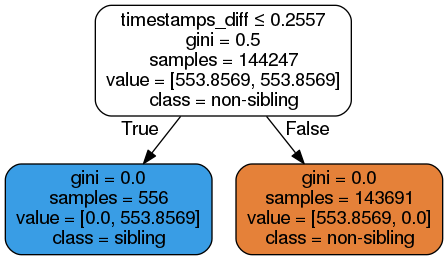

In [690]:
Image(graphs[-1][-1].create_png())  

In [731]:
df = mix_sib_nonsib(sib, nonsib, "full", 42)
df_ours = df[["label", "decision"]].copy()
dec2prd_ours(df_ours)
undec = len(df_ours[df_ours.isnull().any(axis=1)])
print("Our algo: Not deciding on {} pairs for unknown/error reasons.".format(undec))
df_ours = df_ours.dropna()
print("Our algo stats: ({}) undecided".format(undec))
a = stats(df_ours["label"], df_ours["dec_prd"])

Our algo: Not deciding on 1417 pairs for unknown/error reasons.
Our algo stats: (1417) undecided
Correct: 405969, incorrect 24, TP 493, FP 2, TN 405476, FN22, Prec. 99.6, Rec. 95.73, Spec. 100.0, Acc. 99.99%


In [737]:
list(a)
a = list(a)
a.append(5)
a

[99.599999999999994, 95.730000000000004, 100.0, 99.989999999999995, 5, 5]

In [693]:
from sklearn.metrics import f1_score
f1_score(df_ours["label"], df_ours["dec_prd"])

0.97623762376237622

In [695]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(df_ours["label"], df_ours["dec_prd"])

0.97639996941410645

## Evaluate Hand-Tuned Algo For Overfitting

1. Calculate Training Error
1. Evaluate only new hosts to get Test error

In [109]:
for i in range(1,2):
    print("############# Round {} ##############".format(i))
    sib, nonsib = get_pd_files("../../../gt{}/".format(i))
    #print("Columns: {}".format(list(sib.columns.values)))
    get_ouralgo_stats(sib, nonsib)


############# Round 1 ##############
Loading from filenames ../../../gt1/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../gt1/hosts.csv__nonsiblings_seed1_n679capture.pcap.ts.siblingresult.csv
Read 279 siblings and 82026 non-siblings from files.
Our algo: Not deciding on 70 pairs for unknown/error reasons.
Our algo stats: (70) undecided
Correct: 82229, incorrect 6, TP 255, FP 0, TN 81974, FN6, Prec. 100.0, Rec. 97.7, Spec. 100.0, Acc. 99.99%


In [136]:
for i in range(2,8):
    print("############# Round {} ##############".format(i))
    sib, nonsib = get_pd_files("../../../algo-eval/gt{}/".format(i))
    #print("Columns: {}".format(list(sib.columns.values)))
    get_ouralgo_stats(sib, nonsib)


############# Round 2 ##############
Loading from filenames ../../../algo-eval/gt2/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../algo-eval/gt2/hosts.csv__nonsiblings_seed1_n407_capture.pcap.ts.siblingresult.csv
Read 369 siblings and 145041 non-siblings from files.
Our algo: Not deciding on 32 pairs for unknown/error reasons.
Our algo stats: (32) undecided
Correct: 145365, incorrect 13, TP 328, FP 2, TN 145037, FN11, Prec. 99.39, Rec. 96.76, Spec. 100.0, Acc. 99.99%
############# Round 3 ##############
Loading from filenames ../../../algo-eval/gt3/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../algo-eval/gt3/hosts.csv__nonsiblings_seed1_n407_capture.pcap.ts.siblingresult.csv
Read 370 siblings and 145804 non-siblings from files.
Our algo: Not deciding on 44 pairs for unknown/error reasons.
Our algo stats: (44) undecided
Correct: 146113, incorrect 17, TP 317, FP 2, TN 145796, FN15, Prec. 99.37, Rec. 95.48, Spec. 100.0, Acc. 99.99%
############# Round 4 ##############
Loa

In [137]:
for i in range(2,8):
    print("############# Round {} ##############".format(i))
    #sib, nonsib = get_pd_files("../../../eval-algo/gt{}/".format(i))
    groups = assign_groups(sib)
    groupset = set(groups)
    for i in groupset:
        print("## GROUP: {}".format(i))
        groupsib = sib[sib["group"] == i].copy()
        groupnonsib = match_nonsibs(groupsib, nonsib)
        get_ouralgo_stats(groupsib, groupnonsib)
        #get_bev_stats(groupsib, groupnonsib)


############# Round 2 ##############
## GROUP: RAv1
Generated 132 non-sibling candidates from 12 siblings.
Our algo: Not deciding on 2 pairs for unknown/error reasons.
Our algo stats: (2) undecided
Correct: 142, incorrect 0, TP 12, FP 0, TN 130, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
## GROUP: RAv2
Generated 41006 non-sibling candidates from 203 siblings.
Our algo: Not deciding on 5 pairs for unknown/error reasons.
Our algo stats: (5) undecided
Correct: 41199, incorrect 5, TP 200, FP 2, TN 40999, FN3, Prec. 99.01, Rec. 98.52, Spec. 100.0, Acc. 99.99%
## GROUP: nlnog
Generated 18360 non-sibling candidates from 136 siblings.
Our algo: Not deciding on 316 pairs for unknown/error reasons.
Our algo stats: (316) undecided
Correct: 18173, incorrect 7, TP 86, FP 0, TN 18087, FN7, Prec. 100.0, Rec. 92.47, Spec. 100.0, Acc. 99.96%
## GROUP: servers
Generated 306 non-sibling candidates from 18 siblings.
Our algo: Not deciding on 2 pairs for unknown/error reasons.
Our algo stats: (

# High-Level Comparison of Results

In [9]:
for i in range(7,8):
    print("############# Round {} ##############".format(i))
    sib, nonsib = get_pd_files("../../../gt{}/".format(i))
    #print("Columns: {}".format(list(sib.columns.values)))
    get_ouralgo_stats(sib, nonsib)
    get_bev_stats(sib, nonsib)
    nonsibfil = match_nonsibs(sib, nonsib)

############# Round 7 ##############
Loading from filenames ../../../gt7/hosts.csvcapture.pcap.ts.siblingresult.csv and ../../../gt7/hosts.csv__nonsiblings_seed1_n681capture.pcap.ts.siblingresult.csv
Read 618 siblings and 406792 non-siblings from files.
Our algo: Not deciding on 1417 pairs for unknown/error reasons.
Our algo stats: (1417) undecided
Correct: 405969, incorrect 24, TP 493, FP 2, TN 405476, FN22, Prec. 99.6, Rec. 95.73, Spec. 100.0, Acc. 99.99%
Beverly algo stats:
Beverly algo: Not deciding on 1315 pairs for NaN and 0 pairs for unknown/error reasons.
Beverly algo stats: (0) undecided
Correct: 331420, incorrect 74675, TP 613, FP 74671, TN 330807, FN4, Prec. 0.81, Rec. 99.35, Spec. 81.58, Acc. 81.61%
Generated 381306 non-sibling candidates from 618 siblings.


# Comparison of results at group level

In [84]:
for i in range(2,3):
    print("############# Round {} ##############".format(i))
    #sib, nonsib = get_pd_files("../../../gt{}/".format(i))
    groups = assign_groups(sib)
    groupset = set(groups)
    for i in groupset:
        print("## GROUP: {}".format(i))
        groupsib = sib[sib["group"] == i].copy()
        groupnonsib = match_nonsibs(groupsib, nonsib)
        get_ouralgo_stats(groupsib, groupnonsib)
        get_bev_stats(groupsib, groupnonsib)
    #print("Columns: {}".format(list(sib.columns.values)))
    #get_ouralgo_stats(sib, nonsib)
    #get_bev_stats(sib, nonsib)
    #nonsibfil = match_nonsibs(sib, nonsib)

############# Round 2 ##############
## GROUP: RAv1
Generated 132 non-sibling candidates from 12 siblings.
Our algo: Not deciding on 0 pairs for unknown/error reasons.
Our algo stats: (0) undecided
Correct: 144, incorrect 0, TP 12, FP 0, TN 132, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
Beverly algo stats:
Beverly algo: Not deciding on 0 pairs for NaN and 0 pairs for unknown/error reasons.
Beverly algo stats: (0) undecided
Correct: 12, incorrect 132, TP 12, FP 132, TN 0, FN0, Prec. 8.33, Rec. 100.0, Spec. 0.0, Acc. 8.33%
## GROUP: RAv2
Generated 42642 non-sibling candidates from 207 siblings.
Our algo: Not deciding on 4 pairs for unknown/error reasons.
Our algo stats: (4) undecided
Correct: 42837, incorrect 8, TP 199, FP 2, TN 42638, FN6, Prec. 99.0, Rec. 97.07, Spec. 100.0, Acc. 99.98%
Beverly algo stats:
Beverly algo: Not deciding on 4 pairs for NaN and 0 pairs for unknown/error reasons.
Beverly algo stats: (0) undecided
Correct: 16785, incorrect 26060, TP 204, FP 26059,

{'RAv1', 'RAv2', 'nlnog', 'servers'}

# ML with proportional group sampling

Strategy: 
1. take siblings from each group and generate 10 ShuffleSplit iterations
2. create matching nonsibs and mix all
3. adjust weights


In [621]:
# functions for ML with proprtional group sampling
def split_stratified_groups(sib, splits, nr):
    from sklearn.model_selection import KFold # non-overlapping!
    groups = assign_groups(sib)
    groupset = set(groups)
    gsibdf_train = pd.DataFrame(columns=sib.columns)
    gsibdf_test = pd.DataFrame(columns=sib.columns)
    for i in groupset:
        groupsib = sib[sib["group"] == i].copy()
        #print("## GROUP: {} with {} elements.".format(i, len(groupsib)))
        ks = KFold(n_splits=splits, random_state=42, shuffle=True)
        labels, features = make_labels_features(groupsib)
        ctr = -1
        for train_index, test_index in ks.split(groupsib):
            ctr += 1                
            if (ctr == nr):
            #print("TRAIN:", train_index, "TEST:", test_index)
                gsibdf_train = gsibdf_train.append(groupsib.iloc[train_index])
                gsibdf_test = gsibdf_test.append(groupsib.iloc[test_index])
                break
    return [gsibdf_train, gsibdf_test]


def dt_train(labels, features, weight, rs=42):
    estimator = DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=42)
    est = estimator.fit(features, labels, sample_weight=weight)
    return est

def kfold_train_test(sib, nonsib):
    kfolds = 10
    stats_train_error = np.empty((10,4), dtype=float)
    stats_test_error = np.empty((10,4), dtype=float)
    graphs = []
    for i in range(10):
        print("Round {}".format(i))
        # pick proportionally from each group
        train_sib, test_sib = split_stratified_groups(sib, 10, i)
        # create, select, and mix matching nonsibs
        train_nonsib = match_nonsibs(train_sib, nonsib)
        test_nonsib = match_nonsibs(test_sib, nonsib)
        train = mix_sib_nonsib(train_sib,train_nonsib, "all")
        # prune NaNs out
        train, train_prune_lbl, train_prune_prd = prune_data_for_ml(train)
        test = mix_sib_nonsib(test_sib,test_nonsib, "all")
        test, test_prune_lbl, test_prune_prd = prune_data_for_ml(test)
        # split out features, labels, and weights
        train_lbl, train_ftr = make_labels_features(train)
        test_lbl, test_ftr = make_labels_features(test)
        train_weight = get_sample_weight_one_input(train)
        test_weight = get_sample_weight_one_input(test)
        # train estimator
        est = dt_train(train_lbl, train_ftr, train_weight)   
        stats_train_error[i] = stats(train_lbl, est.predict(train_ftr))
        stats_test_error[i]  =  stats(test_lbl, est.predict(test_ftr))
        graph = dt_plot(est, train_ftr)
        graphs.append(graph)
        #Image(graph.create_png())  
    return stats_train_error, stats_test_error

In [618]:
tre, tee = kfold_train_test(sib, nonsib)

Round 0
Generated 108570 non-sibling candidates from 330 siblings.
Generated 1482 non-sibling candidates from 39 siblings.


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:172: RuntimeWarning: invalid value encountered in long_scalars


Correct: 70828, incorrect 1, TP 0, FP 0, TN 70828, FN1, Prec. nan, Rec. 0.0, Spec. 100.0, Acc. 100.0%
Removing 667 rows with error results and 70829 rows with NaNs (typically hz different) from a     total of 108900 entries, resulting in 38071 entries.
Correct: 991, incorrect 1, TP 0, FP 0, TN 991, FN1, Prec. nan, Rec. 0.0, Spec. 100.0, Acc. 99.9%
Removing 1 rows with error results and 992 rows with NaNs (typically hz different) from a     total of 1521 entries, resulting in 529 entries.
Found 329 sibs and 37742 nonsibs, weights: 0.9914 and 0.0086, #weights: 38071
Found 38 sibs and 491 nonsibs, weights: 0.9282 and 0.0718, #weights: 529
Correct: 38071, incorrect 0, TP 329, FP 0, TN 37742, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
Correct: 529, incorrect 0, TP 38, FP 0, TN 491, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
Round 1
Generated 108570 non-sibling candidates from 330 siblings.
Generated 1482 non-sibling candidates from 39 siblings.
Correct: 70452, incorr

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:173: RuntimeWarning: invalid value encountered in long_scalars


Round 3
Generated 109892 non-sibling candidates from 332 siblings.
Generated 1332 non-sibling candidates from 37 siblings.
Correct: 71593, incorrect 2, TP 0, FP 0, TN 71593, FN2, Prec. nan, Rec. 0.0, Spec. 100.0, Acc. 100.0%
Removing 670 rows with error results and 71595 rows with NaNs (typically hz different) from a     total of 110224 entries, resulting in 38629 entries.
Correct: 890, incorrect 0, TP 0, FP 0, TN 890, FN0, Prec. nan, Rec. nan, Spec. 100.0, Acc. 100.0%
Removing 2 rows with error results and 890 rows with NaNs (typically hz different) from a     total of 1369 entries, resulting in 479 entries.
Found 330 sibs and 38299 nonsibs, weights: 0.9915 and 0.0085, #weights: 38629
Found 37 sibs and 442 nonsibs, weights: 0.9228 and 0.0772, #weights: 479
Correct: 38629, incorrect 0, TP 330, FP 0, TN 38299, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
Correct: 479, incorrect 0, TP 37, FP 0, TN 442, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%
Round 4
Generated 109

In [619]:
tre

array([[ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.],
       [ 100.,  100.,  100.,  100.]])

In [620]:
tee

array([[ 100.  ,  100.  ,  100.  ,  100.  ],
       [ 100.  ,  100.  ,  100.  ,  100.  ],
       [ 100.  ,  100.  ,  100.  ,  100.  ],
       [ 100.  ,  100.  ,  100.  ,  100.  ],
       [ 100.  ,  100.  ,  100.  ,  100.  ],
       [  94.87,  100.  ,   99.53,   99.57],
       [ 100.  ,  100.  ,  100.  ,  100.  ],
       [ 100.  ,  100.  ,  100.  ,  100.  ],
       [ 100.  ,  100.  ,  100.  ,  100.  ],
       [ 100.  ,  100.  ,  100.  ,  100.  ]])

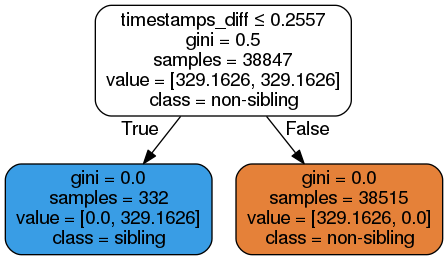

In [683]:
Image(graph.create_png())  

In [608]:
for i in graphs:
    Image(i.create_png())  

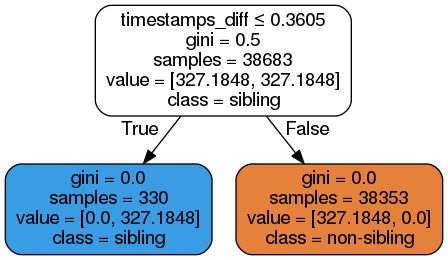

In [615]:
Image(graphs[5].create_png())  

In [598]:
train_lbl.as_matrix()

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

# Old and unused approaches

# ML test with shuffled, pseudo-stratified group sampling

Strategy: 
1. take siblings from each group and generate 10 ShuffleSplit iterations
2. create matching nonsibs and mix all
3. adjust weights

In [407]:
#groups = assign_groups(sib)
#from sklearn.model_selection import ShuffleSplit # shufflesplit does not generate non-overlapping splits!
#from sklearn.model_selection import KFold # non-overlapping!

In [408]:
def split_stratified_groups(sib, splits, nr):
    from sklearn.model_selection import KFold # non-overlapping!
    groups = assign_groups(sib)
    groupset = set(groups)
    gsibdf_train = pd.DataFrame(columns=sib.columns)
    gsibdf_test = pd.DataFrame(columns=sib.columns)
    for i in groupset:
        groupsib = sib[sib["group"] == i].copy()
        print("## GROUP: {} with {} elements.".format(i, len(groupsib)))
        ks = KFold(n_splits=splits, random_state=42, shuffle=True)
        labels, features = make_labels_features(groupsib)
        ctr = 0
        for train_index, test_index in ks.split(groupsib):
            ctr += 1
            if (ctr == nr):
            #print("TRAIN:", train_index, "TEST:", test_index)
                gsibdf_train = gsibdf_train.append(groupsib.iloc[train_index])
                gsibdf_test = gsibdf_test.append(groupsib.iloc[test_index])
                break
    return [gsibdf_train, gsibdf_test]

In [409]:
train_sib, test_sib = split_stratified_groups(sib, 10, 1)

## GROUP: RAv1 with 12 elements.
## GROUP: RAv2 with 203 elements.
## GROUP: nlnog with 136 elements.
## GROUP: servers with 18 elements.


In [410]:
train_nonsib = match_nonsibs(train_sib, nonsib)
test_nonsib = match_nonsibs(test_sib, nonsib)

Generated 108570 non-sibling candidates from 330 siblings.
Generated 1482 non-sibling candidates from 39 siblings.


In [531]:
train = mix_sib_nonsib(train_sib,train_nonsib, "all")
train, train_prune_lbl, train_prune_prd = prune_data_for_ml(train)
test = mix_sib_nonsib(test_sib,test_nonsib, "all")
test, test_prune_lbl, test_prune_prd = prune_data_for_ml(test)

Correct: 70828, incorrect 1, TP 0, FP 0, TN 70828, FN1, Prec. nan, Rec. 0.0, Spec. 100.0, Acc. 100.0%
Removing 667 rows with error results and 70829 rows with NaNs (typically hz different) from a     total of 108900 entries, resulting in 38071 entries.
Correct: 991, incorrect 1, TP 0, FP 0, TN 991, FN1, Prec. nan, Rec. 0.0, Spec. 100.0, Acc. 99.9%
Removing 1 rows with error results and 992 rows with NaNs (typically hz different) from a     total of 1521 entries, resulting in 529 entries.


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:172: RuntimeWarning: invalid value encountered in long_scalars


In [532]:
train_lbl, train_ftr = make_labels_features(train)
test_lbl, test_ftr = make_labels_features(test)

In [533]:
train_weight = get_sample_weight_one_input(train)
test_weight = get_sample_weight_one_input(test)

Found 329 sibs and 37742 nonsibs, weights: 0.9914 and 0.0086, #weights: 38071
Found 38 sibs and 491 nonsibs, weights: 0.9282 and 0.0718, #weights: 529


In [549]:
def dt_train(labels, features, weight, rs=42):
    estimator = DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, random_state=42)
    est = estimator.fit(features, labels, sample_weight=weight)
    return est

In [550]:
est = dt_train(train_lbl, train_ftr, train_weight)

In [551]:
## WIP TODO now build scoring function

In [552]:
prd = est.predict(train_ftr)

In [553]:
print("score: {}".format(est.score(train_ftr, train_lbl, sample_weight=train_weight)))

score: 1.0


In [554]:
stats(train_lbl, prd)

Correct: 38071, incorrect 0, TP 329, FP 0, TN 37742, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%


In [555]:
stats(test_lbl, est.predict(test_ftr))

Correct: 529, incorrect 0, TP 38, FP 0, TN 491, FN0, Prec. 100.0, Rec. 100.0, Spec. 100.0, Acc. 100.0%


In [547]:
def dt_plot(estimator, features):
    from sklearn import tree
    dot_data = tree.export_graphviz(estimator, out_file=None, 
                         feature_names=list(features.columns.values),  
                         class_names=["non-sibling", "sibling"],  
                         filled=True, rounded=True,  
                         special_characters=True) 
    import pydotplus
    graph = pydotplus.graph_from_dot_data(dot_data) 
    
    return graph
    #print("score: {}".format(est.score(features_test, labels_test, sample_weight=weights_test)))
    # return prd, lbl, graph

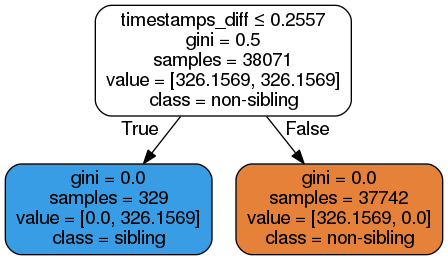

In [556]:
graph = dt_plot(est, train_ftr)
Image(graph.create_png())  